# Construction d'un indicateur google trends

In [1]:
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
import seaborn as sns
import math 
import matplotlib.pyplot as plt

Fonctions utilisées

In [2]:
# on veut regrouper ces df par mois pour pouvoir les comparer avec les valeurs officielles 
def grouper_par_mois (df):
    """je commence par faire des regroupements par date"""
    df['Year'] = df['date'].dt.year 
    df['Month'] = df['date'].dt.month 
    df['Year-Month'] = df['date'].dt.strftime('%Y-%m')
    df=df.drop(["date","Year", "Month"], axis=1)
    df_par_mois=df.groupby('Year-Month').sum()
    
    return df_par_mois 

In [3]:
# je standardise mes sommes obtenues
def standardiser (df):
    """puis je restandardise mes données"""
    df_par_mois=grouper_par_mois(df)
    df_par_mois=df_par_mois.reset_index()
    df_par_mois2=df_par_mois.drop(["Year-Month"], axis=1)
    df_par_mois2 = (df_par_mois2 - df_par_mois2.min(axis=0)) / (df_par_mois2.max(axis=0) - df_par_mois2.min(axis=0))
    df_par_mois_dates=df_par_mois[["Year-Month"]]
    df_par_mois_std = df_par_mois2.merge(df_par_mois_dates, how='inner', left_index=True, right_index=True)
    
    return df_par_mois_std

In [4]:
def base_donnees_officielles_region (liste_departements, df_official_data):
    """on somme les touristes des bons départements"""
    df = df_official_data[df_official_data['department'].isin(liste_departements)]
    df=df.drop(["department"], axis=1)
    df=df.groupby("date").sum()
    df=df.reset_index()
    """on crée un format compatible pour la jointure plus tard """
    df['Year'] = df['date'].dt.year 
    df['Month'] = df['date'].dt.month 
    df['Year-Month'] = df['date'].dt.strftime('%Y-%m')
    df=df.drop(["date", "Year", "Month"], axis=1)
    return df

In [5]:
def fonction_lasso_non_aleatoire(df):
    "sert à sélectionner les google trends pertinentes"

    """je définis mon vecteur cible y (à prédire) et mes variables (X, les google trends)"""
    """je définis mes échantillons de train et de test de manière non aléatoire: entrainement avant 2019, test après 2019 """
   
    X_train = df[df["Year-Month"]<="2018"]
    X_train=X_train.drop(["Year-Month"], axis = 1)
    X_train=X_train.drop(["value_in_thousands"], axis = 1).to_numpy()
    
    X_test = df[df["Year-Month"]>"2019"]
    X_test=X_test.drop(["Year-Month"], axis = 1)
    X_test=X_test.drop(["value_in_thousands"], axis = 1).to_numpy()
    
    
    y_train = df[df["Year-Month"]<="2018"]
    y_train=y_train.drop(["Year-Month"], axis = 1)
    y_train= y_train["value_in_thousands"].to_numpy()
    
    y_test= df[df["Year-Month"]>"2019"]
    y_test=y_test.drop(["Year-Month"], axis = 1)
    y_test= y_test["value_in_thousands"].to_numpy()
    


    pipeline = Pipeline([
                         ('scaler',StandardScaler()),
                         ('model',Lasso())
    ])

    search = GridSearchCV(pipeline,
                          {'model__alpha':np.arange(0.1,10,0.1)},
                          cv = 5, scoring="neg_mean_squared_error",verbose=3
                          )

    """entrainement"""  
    search.fit(X_train,y_train)
    search.best_params_
    coefficients = search.best_estimator_.named_steps['model'].coef_
    importance = np.abs(coefficients)

    """test""" 
    search.fit(X_test,y_test)
    search.best_params_
    coefficients = search.best_estimator_.named_steps['model'].coef_
    importance_finale = np.abs(coefficients)
    importance_finale

    return importance_finale

In [6]:
def gt_moyenne(df):
    "sert à représenter la moyenne des gt sélectionnées"
    df=df.set_index("date")
    df["moyenne"]=df.mean(axis=1,skipna = True)
    df=df.reset_index()

    #on représente graphiquement
    x=df[["date"]]
    y=df[["moyenne"]]
    z = df["moyenne"].rolling(window = 14).mean()
    fig = plt.figure(1, figsize=(20, 5))
    plt.plot(x, z)
    plt.title('Tourisme prédiction avec les google trends (moyenne roulante sur les gt sélectionnées avec le lasso)')
    plt.xlabel('Date')
    plt.ylabel("Valeur de l'indicateur")
    plt.legend()

    return df

In [7]:
def calcul_moyenne (df): 
    "sert à calculer la moyenne des gt journalières après avoir retiré les gt non sélectionnées par le LASSO"
    #nb_touristes=df[["value_in_thousands", "Year-Month"]]
    calcul_moyenne=df.drop(["Year", "Month", "Year-Month"], axis=1)
    calcul_moyenne["moyenne"]=calcul_moyenne.mean(axis=1,skipna = True)
    base_moyenne=calcul_moyenne #.merge(nb_touristes, how="inner", left_on="Year-Month", right_on="Year-Month")
    return base_moyenne

In [8]:
def nb_touristes (df_base, df_official):
    "calcule le nb de touristes final après avoir enlevé les gg trends non sélectionnés par le LASSO"
    df_moyenne=calcul_moyenne(df_base)
    df_moyenne=df_moyenne[["date", "moyenne"]]
    df_moyenne["indicateur"]=((df_moyenne["moyenne"]-df_moyenne['moyenne'].mean())/df_moyenne['moyenne'].std())*df_official['value_in_thousands'].std()+df_official['value_in_thousands'].mean()
    df_moyenne['indicateur'][df_moyenne["indicateur"]<0]=0
    df_moyenne["moyenne_mobile"] = df_moyenne[['indicateur']].rolling(window = 14).mean()
    return df_moyenne

In [10]:
# Importation des bases de données

# données officielles
df_France_Official_Data = pd.read_csv('France_Official_Data.csv')
df_France_Official_Data['date']=pd.to_datetime(df_France_Official_Data['date'])
df_France_Official_Data['value_in_thousands']=pd.to_numeric(df_France_Official_Data['value_in_thousands'], errors='coerce')
df_France_Official_Data2 = df_France_Official_Data.groupby(['date', 'department'], as_index=False).sum() 


# données google trends
gt_longer_1= pd.read_csv("google_trends_fr_longer.csv")
gt_longer_bis=pd.read_csv("google_trends_fr_longer_2.csv")

# on concatène les données
gt_longer = pd.concat([gt_longer_1, gt_longer_bis])
gt_longer.sort_values(by=['variable'], inplace=True)

gt_longer['date']=pd.to_datetime(gt_longer['date'])
gt_longer = gt_longer.reset_index().pivot_table(values = "value", index = "date", columns = "variable")
gt_longer=gt_longer.reset_index()
# (je standardise mes données)
gt_longer2=gt_longer.drop(["date"], axis=1)
gt_longer_std = (gt_longer2 - gt_longer2.min(axis=0)) / (gt_longer2.max(axis=0) - gt_longer2.min(axis=0))
gt_longer_dates=gt_longer[["date"]]
# (je regroupe tout dans un seul database)
gt_longer_std = gt_longer_std.merge(gt_longer_dates, how='inner', left_index=True, right_index=True)

In [11]:
# je fais la liste des départements par région:
departements_bretagne=["Finistère", "Côtes-d'Armor", "Morbihan", "Ille-et-Vilaine"]
departements_hauts_france=["Pas-de-Calais", "Nord", "Somme", "Oise"]
departements_bourgogne=["Yonne", "Nièvre", "Côte-d'Or", "Haute-Saône", "Saône-et-Loire", "Jura", "Doubs"]
departements_grand_est=["Ardennes", "Marne", "Aude", "Meuse", "Haute-Marne", "Moselle", "Meurthe-et-Moselle", "Vosges", "Bas-Rhin", 'Haut-Rhin']
departements_corse=["Haute-Corse", "Basse-Corse"]

departements_languedoc=["Lot", "Aveyron", "Lozère","Tarn-et-Garonne", "Tarn","Hérault", "Gard","Gers", "Haute-Garonne", "Hautes-Pyréenées", "Ariège", "Aude", "Pyrénées orientales"]
departements_loire=["Loire-Atlantique","Maine-et-Loire", "Mayenne", "Sarthe", "Vendée"]
departements_normandie=["Calvaodos", "Eure", "Manche", "Orne", "Seine-Maritime"]
departements_nouv_aq=["Charente","Charente-Maritime","Corrèze","Creuse","Landes", "Dordogne","Gironde","Lot-et-Garonne", "Pyrénées-Atlantiques", "Deux-Sèvres", "Vienne", "Haute-Vienne"]
departements_paca=["Alpes-Maritimes", "Hautes-Alpes", "Alpes de Haute-Provence","Bouches-du-Rhône", "Var","Vaucluse"]
departements_idf=["Paris", "Hauts-de-Seine", "Seine-Saint-Denis", "Val-de-Marne","Val d'Oise", "Yvelines", "Essonne","Seine-et-Marne"]
departements_rhône=["Loire", "Rhône","Ain", "Haute-Savoie", "Ardèche", "Drôme", "Isère", "Savoie", "Allier","Puy-de-Dôme", "Cantal", "Haute-Loire"]

In [12]:
# je crée mes bdd pour chaque région touristique: on sélectionne les gt pour chaque région et on fait des opérations de standardisation
gt_bretagne_l= gt_longer_std[["brest theme_cat_voyages", "bretagne theme_cat_voyages",'quimper theme_cat_voyages', 'rennes theme_cat_voyages', "date"]]
gt_hauts_france_l= gt_longer_std[['amiens theme_cat_voyages','dunkerque theme_cat_voyages','lille europe theme_cat_voyages', 'lille theme_cat_voyages', 'aeroport lille theme_cat_voyages', "date"]]
gt_bourgogne_l= gt_longer_std[["beaune theme_cat_voyages", 'bourgogne franche comte theme_cat_voyages','dijon theme_cat_voyages', "date"]]
gt_grand_est_l= gt_longer_std[['strasbourg airport_cat_voyages', 'strasbourg hotel_cat_voyages','strasbourg restaurant_cat_voyages', 'strasbourg_cat_voyages', "date"]]
gt_corse_l= gt_longer_std[['calvi theme_cat_voyages','corse_cat_voyages', 'corsica ferries theme_cat_voyages', "date"]]

gt_languedoc_l= gt_longer_std[["narbonne theme_cat_voyages", "perpignan theme_cat_voyages", "date"]]
gt_pays_loire_l= gt_longer_std[["la baule theme_cat_voyages", "nantes theme", "date"]]
gt_normandie_l= gt_longer_std[["mont saint michel theme_cat_voyages", "caen theme_cat_voyages", "date"]]
gt_nouvelle_aquitaine_l= gt_longer_std[["date", "arcachon theme_cat_voyages", "biarritz theme_cat_voyages", "bordeaux theme_cat_voyages", "la rochelle theme_cat_voyages"]]
gt_paca_l= gt_longer_std[["date","marseille gare_cat_voyages", "marseille hotel_cat_voyages", "marseille restaurant_cat_voyages","mucem theme","marseille vieux port_cat_voyages","marseille station_cat_voyages", "marseille_cat_voyages", "nice airport_cat_voyages","aeroport nice cote d azur theme_cat_voyages","cote d azur theme_cat_voyages", "french riviera_cat_voyages","nice hotel_cat_voyages","nice_cat_voyages", "promenade des anglais_cat_voyages"]]
gt_idf_l= gt_longer_std[["date","aeroport paris_cat_voyages", "disneyland paris hotel_cat_voyages","disneyland paris theme_cat_voyages","disneyland paris_cat_voyages","louvre_cat_voyages","paris gare_cat_voyages","paris hotel_cat_voyages","paris restaurant_cat_voyages","paris_cat_voyages"]]
gt_rhône_l= gt_longer_std[["date","lyon gare_cat_voyages", "lyon hotel_cat_voyages", "auvergne theme_cat_voyages", "volcans auvergne theme_cat_voyages"]]

In [13]:
# on regroupe par mois pour pouvoir faire une fusion avec les données officielles 
gt_bretagne_l_2= standardiser(gt_bretagne_l)
gt_hauts_france_l_2= standardiser(gt_hauts_france_l)
gt_bourgogne_l_2= standardiser(gt_bourgogne_l)
gt_grand_est_l_2= standardiser(gt_grand_est_l)
gt_corse_l_2 = standardiser(gt_corse_l)

gt_languedoc_l_2= standardiser(gt_languedoc_l)
gt_pays_loire_l_2= standardiser(gt_pays_loire_l)
gt_normandie_l_2= standardiser(gt_normandie_l)
gt_nouvelle_aquitaine_l_2=standardiser(gt_nouvelle_aquitaine_l)
gt_paca_l_2=standardiser(gt_paca_l)
gt_idf_l_2= standardiser(gt_idf_l)
gt_rhône_l_2=standardiser(gt_rhône_l)

# on crée une bdd avec les données officielles pour chaque région
bretagne_officiel = base_donnees_officielles_region(departements_bretagne,df_France_Official_Data2)
hauts_france_officiel = base_donnees_officielles_region(departements_hauts_france,df_France_Official_Data2)
bourgogne_officiel = base_donnees_officielles_region(departements_bourgogne,df_France_Official_Data2)
grand_est_officiel = base_donnees_officielles_region(departements_grand_est,df_France_Official_Data2)
corse_officiel = base_donnees_officielles_region(departements_corse,df_France_Official_Data2)

languedoc_officiel = base_donnees_officielles_region(departements_languedoc,df_France_Official_Data2)
loire_officiel = base_donnees_officielles_region(departements_loire,df_France_Official_Data2)
normandie_officiel = base_donnees_officielles_region(departements_normandie,df_France_Official_Data2)
nouvelle_aquitaine_officiel = base_donnees_officielles_region(departements_nouv_aq,df_France_Official_Data2)
paca_officiel = base_donnees_officielles_region(departements_paca,df_France_Official_Data2)
idf_officiel = base_donnees_officielles_region(departements_idf,df_France_Official_Data2)
rhone_officiel = base_donnees_officielles_region(departements_rhône,df_France_Official_Data2)

# On va fusionner les bases 
base_bretagne_l= bretagne_officiel.merge(gt_bretagne_l_2, how="inner", on="Year-Month")
base_hauts_france_l= hauts_france_officiel.merge(gt_hauts_france_l_2, how="inner", on="Year-Month")
base_bourgogne_l= bourgogne_officiel.merge(gt_bourgogne_l_2, how="inner", on="Year-Month")
base_grand_est_l= grand_est_officiel.merge(gt_grand_est_l_2, how="inner", on="Year-Month")
base_corse_l= corse_officiel.merge(gt_corse_l_2, how="inner", on="Year-Month")

base_languedoc_l= languedoc_officiel.merge(gt_languedoc_l_2, how="inner", on="Year-Month")
base_loire_l= loire_officiel.merge(gt_pays_loire_l_2, how="inner", on="Year-Month")
base_normandie_l= normandie_officiel.merge(gt_normandie_l_2, how="inner", on="Year-Month")
base_nouvelle_aq_l= nouvelle_aquitaine_officiel.merge(gt_nouvelle_aquitaine_l_2, how="inner", on="Year-Month")
base_idf_l= idf_officiel.merge(gt_idf_l_2, how="inner", on="Year-Month")
base_paca_l= paca_officiel.merge(gt_paca_l_2, how="inner", on="Year-Month")
base_rhone_l= rhone_officiel.merge(gt_rhône_l_2, how="inner", on="Year-Month")

<ipython-input-2-2063b68eab8e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'] = df['date'].dt.year
<ipython-input-2-2063b68eab8e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Month'] = df['date'].dt.month
<ipython-input-2-2063b68eab8e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

In [ ]:
# on effectue un lASSO pour chaque base afin de supprimer des google trends superflues
# fonction_lasso_non_aleatoire(base_bretagne_l) # on ne rejette aucun google trend
# fonction_lasso_non_aleatoire(base_hauts_france_l) # on ne rejette aucun google trend
# fonction_lasso_non_aleatoire(base_bourgogne_l) # on rejette bourgogne franche comte theme_cat_voyages
# fonction_lasso_non_aleatoire(base_grand_est_l) # on rejette strasbourg airport_cat_voyages
# fonction_lasso_non_aleatoire(base_corse_l) # on rejette corse_cat_voyages

# fonction_lasso_non_aleatoire(base_languedoc_l) # on ne rejette aucun google trend
# fonction_lasso_non_aleatoire(base_loire_l) # on ne rejette rien
# fonction_lasso_non_aleatoire(base_normandie_l) # on ne rejette rien 
# fonction_lasso_non_aleatoire(base_nouvelle_aq_l) # on ne rejette rien
# fonction_lasso_non_aleatoire(base_idf_l) # on rejette disneyland paris_cat_voyages
# fonction_lasso_non_aleatoire(base_paca_l) # on rejette nice hotel_cat_voyages	nice_cat_voyages	promenade des anglais_cat_voyages cote d azur theme_cat_voyages marseille_cat_voyages 
# fonction_lasso_non_aleatoire(base_rhone_l) # on ne rejette aucune utilisation 

In [14]:
# on supprime les google trends non sélectionnées par le LASSO
gt_idf_l=gt_idf_l.drop(["disneyland paris_cat_voyages"], axis=1)
gt_paca_l=gt_paca_l.drop(["nice hotel_cat_voyages","nice_cat_voyages","promenade des anglais_cat_voyages", "cote d azur theme_cat_voyages", "marseille_cat_voyages"], axis=1)
gt_bourgogne_l=gt_bourgogne_l.drop(["bourgogne franche comte theme_cat_voyages"], axis=1)
gt_grand_est_l= gt_grand_est_l.drop(["strasbourg airport_cat_voyages"], axis=1)
gt_corse_l = gt_corse_l.drop(["corse_cat_voyages"], axis=1)

In [15]:
# on calcule le nb de touristes pour chaque région
moyenne_bretagne_long=nb_touristes(gt_bretagne_l,bretagne_officiel)
moyenne_hauts_france_long=nb_touristes(gt_hauts_france_l,hauts_france_officiel)
moyenne_bourgogne_long=nb_touristes(gt_bourgogne_l,bourgogne_officiel)
moyenne_grand_est_long=nb_touristes(gt_grand_est_l,grand_est_officiel)
moyenne_corse_long=nb_touristes(gt_corse_l,corse_officiel)

moyenne_languedoc_long=nb_touristes(gt_languedoc_l,languedoc_officiel)
moyenne_loire_long=nb_touristes(gt_pays_loire_l,loire_officiel)
moyenne_normandie_long=nb_touristes(gt_normandie_l,normandie_officiel)
moyenne_nouvelle_aq_long=nb_touristes(gt_nouvelle_aquitaine_l,nouvelle_aquitaine_officiel)
moyenne_idf_long=nb_touristes(gt_idf_l, idf_officiel)
moyenne_paca_long=nb_touristes(gt_paca_l, paca_officiel)
moyenne_rhone_long=nb_touristes(gt_rhône_l, rhone_officiel)

<ipython-input-7-f39dd89efcbc>:5: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  calcul_moyenne["moyenne"]=calcul_moyenne.mean(axis=1,skipna = True)
<ipython-input-8-77529f602203>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_moyenne['indicateur'][df_moyenne["indicateur"]<0]=0
<ipython-input-7-f39dd89efcbc>:5: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  calcul_moyenne["moyenne"]=calcul_moyenne.mean(axis=1,skipna = True)
<ipython-input-8-77529f602203>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

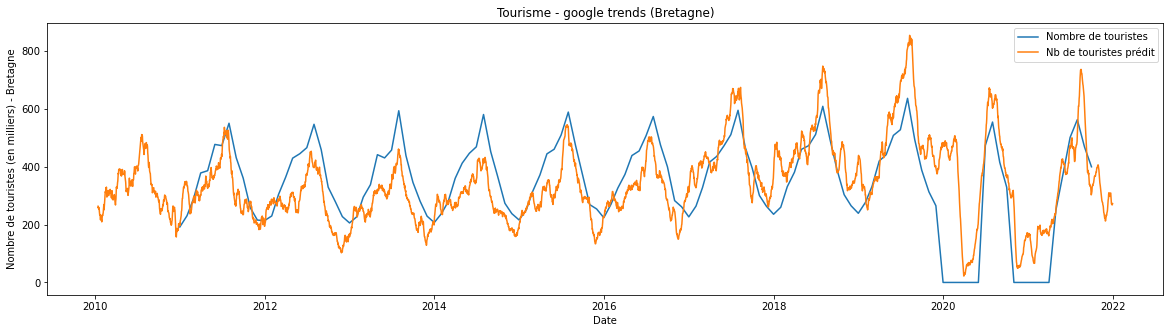

In [16]:
# on visualise les résultats 
moyenne_bretagne_long['date'] = pd.to_datetime(moyenne_bretagne_long['date'], format='%Y-%m-%d') 
bretagne_officiel['Year-Month'] = pd.to_datetime(bretagne_officiel['Year-Month'], format='%Y-%m') 

x2=moyenne_bretagne_long[["date"]]
x3=bretagne_officiel[["Year-Month"]]
y2=bretagne_officiel[["value_in_thousands"]]
y3 =moyenne_bretagne_long[["moyenne_mobile"]]
y4=moyenne_bretagne_long[["indicateur"]]


plt.figure(1, figsize=(20, 5))
plt.plot(x3, y2, label="Nombre de touristes")
plt.plot(x2, y3, label="Nb de touristes prédit")
plt.title('Tourisme - google trends (Bretagne)')
plt.xlabel('Date')
plt.ylabel("Nombre de touristes (en milliers) - Bretagne")
plt.legend()

In [17]:
nb_touristes_France=moyenne_bretagne_long[['date']]
nb_touristes_France['Nombre agrégé']=moyenne_bretagne_long['indicateur'] + moyenne_hauts_france_long['indicateur'] + moyenne_bourgogne_long['indicateur'] + moyenne_grand_est_long['indicateur'] + moyenne_corse_long['indicateur'] + moyenne_languedoc_long['indicateur'] +moyenne_loire_long['indicateur'] + moyenne_normandie_long['indicateur'] + moyenne_nouvelle_aq_long['indicateur']+ moyenne_idf_long['indicateur'] + moyenne_paca_long['indicateur'] + moyenne_rhone_long['indicateur']  
nb_touristes_France['Moyenne mobile']=moyenne_bretagne_long['moyenne_mobile'] + moyenne_hauts_france_long['moyenne_mobile'] + moyenne_bourgogne_long['moyenne_mobile'] + moyenne_grand_est_long['moyenne_mobile'] + moyenne_corse_long['moyenne_mobile'] + moyenne_languedoc_long['moyenne_mobile'] +moyenne_loire_long['moyenne_mobile'] + moyenne_normandie_long['moyenne_mobile'] + moyenne_nouvelle_aq_long['moyenne_mobile']+ moyenne_idf_long['moyenne_mobile'] + moyenne_paca_long['moyenne_mobile'] + moyenne_rhone_long['moyenne_mobile']  

<ipython-input-17-6ac2989dfa62>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nb_touristes_France['Nombre agrégé']=moyenne_bretagne_long['indicateur'] + moyenne_hauts_france_long['indicateur'] + moyenne_bourgogne_long['indicateur'] + moyenne_grand_est_long['indicateur'] + moyenne_corse_long['indicateur'] + moyenne_languedoc_long['indicateur'] +moyenne_loire_long['indicateur'] + moyenne_normandie_long['indicateur'] + moyenne_nouvelle_aq_long['indicateur']+ moyenne_idf_long['indicateur'] + moyenne_paca_long['indicateur'] + moyenne_rhone_long['indicateur']
<ipython-input-17-6ac2989dfa62>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [18]:
# nb de touristes agrégé
df_France_Official_Data3= df_France_Official_Data.groupby(['date'], as_index=False).sum() 

<ipython-input-19-a80bee2c68b3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nb_touristes_France['date'] = pd.to_datetime(nb_touristes_France['date'], format='%Y-%m-%d')


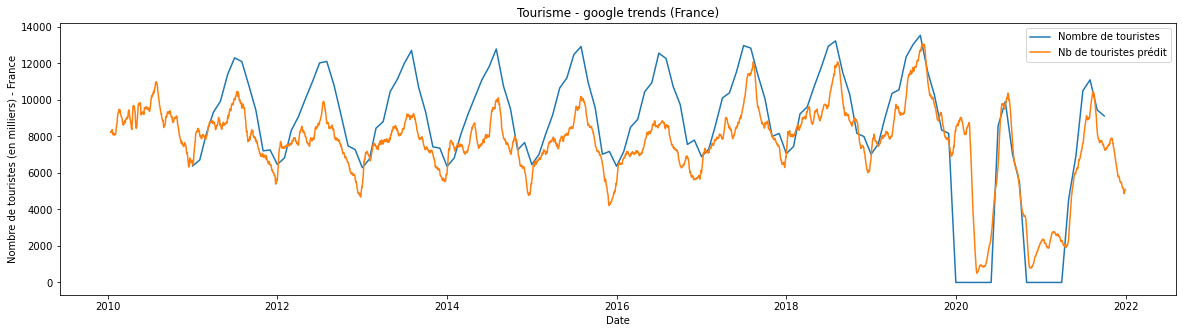

In [19]:
# on visualise les résultats 
nb_touristes_France['date'] = pd.to_datetime(nb_touristes_France['date'], format='%Y-%m-%d') 
df_France_Official_Data3['date'] = pd.to_datetime(df_France_Official_Data3['date'], format='%Y-%m-%d') 

x2=nb_touristes_France[["date"]]
x3=df_France_Official_Data3[["date"]]
y2=df_France_Official_Data3[["value_in_thousands"]]
y3 =nb_touristes_France[["Moyenne mobile"]]


plt.figure(1, figsize=(20, 5))
plt.plot(x3, y2, label="Nombre de touristes")
plt.plot(x2, y3, label="Nb de touristes prédit")
plt.title('Tourisme - google trends (France)')
plt.xlabel('Date')
plt.ylabel("Nombre de touristes (en milliers) - France")
plt.legend()